In [1]:
!pip install networkx
!pip install factor_analyzer 
!pip install plotly

## Data

In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [3]:
root = 'drive/My Drive/Datos Hackathon BBVA'
files = os.listdir(f"{root}")

In [4]:
datasets = []
for i in files:
  print(i)
  datasets.append(pd.read_csv(f"{root}/{i}", delimiter="|").sample(frac=1))

Copia de base 06_V3.csv
Copia de base 02_V3.csv
Copia de base 04_V3.csv
Copia de base 03_V3.csv
Copia de base 05_V3.csv
Copia de base 07_V3 (1).csv
Copia de base 01_V3.csv


In [5]:
for df in datasets:
  df["PERIODO"] = pd.to_datetime(df["PERIODO"].astype(str).apply(lambda s: datetime.datetime(year=int(s[0:4]), month=int(s[4:6]), day=1).strftime('%Y/%-m')))

In [6]:
data_info = {"Sociodemografica": datasets[6], 
             "Adicional": datasets[1], 
             "Productos en BBVA": datasets[3], 
             "Rentabilidad Cliente": datasets[2], 
             "Rentabilidad Cliente Producto": datasets[4], 
             "Detalle Tarjeta de Credito": datasets[0], 
             "RCC": datasets[5]}

In [7]:
data_info["Sociodemografica"].head()

,CODIGO_CLIENTE,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,EDAD,GENERO,UBIGEO_DIRECCION,SEGMENTO_COMERCIAL,ESTADO_CIVIL,AFILIACION_SMS,AFILIACION_BANCA_ONLINE,INGRESO_MENSUAL,GRUPO_RIESGO,DEPENDIENTES,SITUACION_LABORAL,TIPO_EMPLEO,TIPO_PROFESION,PERIODO
504583,89291880,1,30090055,33.0,M,108004.0,1,C,SI,SI,3675.80,1,X,X,X,X,2019-12-01
117272,45485655,1,83237588,20.0,F,101035.0,1,S,SI,SI,832.00,1,X,X,X,X,2021-06-01
427770,98126400,1,78945464,26.0,F,101029.0,1,S,SI,SI,2556.19,1,X,X,X,X,2019-08-01
1520101,23243466,1,29405601,58.0,F,418009.0,1,C,NO,NO,1296.25,0,X,X,X,X,2021-05-01
149722,97458870,1,26496368,65.0,F,101043.0,1,S,NO,NO,1098.75,0,X,X,X,X,2019-02-01


In [8]:
socio_riesgo = data_info["Sociodemografica"][["CODIGO_CLIENTE", "PERIODO", "GRUPO_RIESGO"]]

In [9]:
cambios_riesgo_socio = socio_riesgo.groupby("CODIGO_CLIENTE").nunique().sort_values(by="GRUPO_RIESGO", ascending=False)

In [10]:
clientes_cambio = cambios_riesgo_socio[(cambios_riesgo_socio["GRUPO_RIESGO"] > 1) & (cambios_riesgo_socio["GRUPO_RIESGO"]>=cambios_riesgo_socio["PERIODO"])]

In [11]:
meses_dif = socio_riesgo.copy()
meses_dif.set_index("CODIGO_CLIENTE", inplace=True)

In [12]:
clientes_cambio

,PERIODO,GRUPO_RIESGO
CODIGO_CLIENTE,,
32418220,2,2
51042217,2,2
25609120,2,2
28273283,2,2
47239426,2,2
46907486,2,2
72193224,2,2
49398699,2,2
48197043,2,2


In [13]:
cambios = clientes_cambio.join(meses_dif["PERIODO"], on="CODIGO_CLIENTE",  lsuffix='_left', rsuffix='_right')["PERIODO_right"]

In [14]:
meses_cambios = pd.DataFrame(columns=[1, 2], index=cambios.index.unique())

In [15]:
for i in meses_cambios.index:
  for j in range(1, cambios.loc[i].shape[0]):
    meses_cambios.loc[i, j] = np.abs(cambios.loc[i].iloc[j] - cambios.loc[i].iloc[j-1]).days

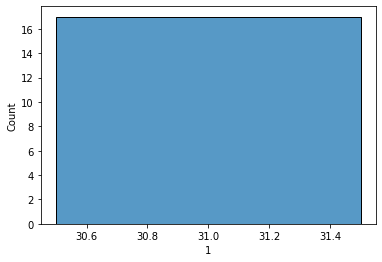

In [16]:
sns.histplot(meses_cambios[1])

In [17]:
st.kstest(list(meses_cambios[1]), 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

El cambio de grupo a través del tiempo es una variable aleatoria con comportamiento normal.

## Rentabilidad Cliente

In [18]:
data_info["Rentabilidad Cliente"].head()

,CODIGO_CLIENTE,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD,PERIODO
407212,6413007,2989.90,120.217899,35.405000,155.622899,5190.661,146.243053,6.612792,27.664417,0.239036,2020-11-01
610641,80626994,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,2021-02-01
832347,65816921,0.00,0.000000,0.503448,0.503448,0.000,0.000000,0.354931,0.088733,4.000002,2020-02-01
71736,79640823,4307.48,154.095790,0.000000,154.095790,0.000,0.000000,108.637532,27.159383,4.000000,2020-07-01
461833,16212611,0.00,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,2020-09-01


In [19]:
data_info["Rentabilidad Cliente"]["Trimestre"] = pd.PeriodIndex(data_info["Rentabilidad Cliente"]["PERIODO"], freq='Q')

In [20]:
rentabilidad_cliente = data_info["Rentabilidad Cliente"].groupby(["Trimestre", "CODIGO_CLIENTE"]).sum()

In [21]:
rentabilidad_cliente.head()

SALDO_PUNTUAL  ...  RATIO_RENTABILIDAD
Trimestre CODIGO_CLIENTE                 ...                    
2020Q1    1484                  1679.05  ...                12.0
          1627                     0.00  ...                 0.0
          2726                  4127.66  ...                12.0
          8020                 17420.82  ...                12.0
          13533                  441.52  ...                12.0

[5 rows x 9 columns]

## Rentabilidad Producto Cliente

In [22]:
data_info["Rentabilidad Cliente Producto"].head()

,CODIGO_CLIENTE,PRODUCTO,DIVISA,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD,PERIODO
147711,55534869,TARJETAS,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-10-01
295603,49197018,CONSUMO,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-01
124639,77267646,CONSUMO,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-04-01
302681,68348917,CONSUMO,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01
223057,40516953,CONSUMO,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-01


In [23]:
data_info["Rentabilidad Cliente Producto"]["Trimestre"] = pd.PeriodIndex(data_info["Rentabilidad Cliente Producto"]["PERIODO"], freq='Q')

In [24]:
rentabilidad_cliente_producto = data_info["Rentabilidad Cliente Producto"].drop(["DIVISA"], axis=1).groupby(["Trimestre", "CODIGO_CLIENTE", "PRODUCTO"]).sum()

In [25]:
rentabilidad_cliente_producto.head()

SALDO_PUNTUAL  ...  RATIO_RENTABILIDAD
Trimestre CODIGO_CLIENTE PRODUCTO                 ...                    
2020Q1    42599          CONSUMO             0.0  ...                 0.0
          54895          CONSUMO             0.0  ...                 0.0
          57262          CONSUMO             0.0  ...                 0.0
          67416          CONSUMO             0.0  ...                 0.0
          78120          TARJETAS            0.0  ...                 0.0

[5 rows x 9 columns]

## Detalle Tarjeta de Crédito

In [26]:
data_info["Detalle Tarjeta de Credito"].head()

,CODIGO_CLIENTE,TIPO_TRANSACCION,TIPO_TARJETA,IMPORTE_TRANSACCION,DETALLE_TRANSACCION1,DETALLE_TRANSACCION2,DETALLE_TRANSACCION3,PERIODO
509655,27665255,0,V5,64.00,Restaurants,RESTAURANTE,RestBar,2018-04-01
736216,84835244,0,V1,97.80,Restaurants,RESTAURANTE,RestBar,2018-08-01
382280,18688275,82,T7,73.35,NaN,NaN,NaN,2019-06-01
1705522,96096113,82,Q1,8.04,NaN,NaN,NaN,2021-03-01
147399,71487633,82,MC,72.52,NaN,NaN,NaN,2018-02-01


In [27]:
data_info["Detalle Tarjeta de Credito"] = data_info["Detalle Tarjeta de Credito"][data_info["Detalle Tarjeta de Credito"]["PERIODO"] >= '2020-01-01']

In [28]:
data_info["Detalle Tarjeta de Credito"]["Trimestre"] = pd.PeriodIndex(data_info["Detalle Tarjeta de Credito"]["PERIODO"], freq='Q')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
data_info["Detalle Tarjeta de Credito"].head()

,CODIGO_CLIENTE,TIPO_TRANSACCION,TIPO_TARJETA,IMPORTE_TRANSACCION,DETALLE_TRANSACCION1,DETALLE_TRANSACCION2,DETALLE_TRANSACCION3,PERIODO,Trimestre
1705522,96096113,82,Q1,8.04,NaN,NaN,NaN,2021-03-01,2021Q1
1650473,90106879,0,V5,51.46,"Supermercados, Minimercados",MERCADO,ProdSuper,2020-03-01,2020Q1
1752421,27864769,87,NaN,5.90,NaN,NaN,NaN,2020-02-01,2020Q1
672038,63691856,0,V1,2.08,Servicio de Taxis y Limousines,VIAJE,TranspLAerea,2020-02-01,2020Q1
1985305,47887722,0,T5,130.00,Hoteles,WEB,AlqBienes,2020-03-01,2020Q1


In [30]:
tarjeta_credito = data_info["Detalle Tarjeta de Credito"][["CODIGO_CLIENTE", "Trimestre", "TIPO_TARJETA", "IMPORTE_TRANSACCION"]].groupby(["Trimestre","CODIGO_CLIENTE", "TIPO_TARJETA"]).sum()

In [31]:
tarjeta_credito["NUM_TRANSACCIONES"] = data_info["Detalle Tarjeta de Credito"][["Trimestre","CODIGO_CLIENTE", "TIPO_TARJETA", "TIPO_TRANSACCION"]].groupby(["Trimestre","CODIGO_CLIENTE", "TIPO_TARJETA"]).count()["TIPO_TRANSACCION"]

In [32]:
tarjeta_credito

IMPORTE_TRANSACCION  NUM_TRANSACCIONES
Trimestre CODIGO_CLIENTE TIPO_TARJETA                                        
2020Q1    90219          T1                        1650.16                 11
          120927         T7                          79.70                  2
          172602         T5                        3330.58                 60
          210540         V5                        3347.72                 29
          256459         V5                        7637.41                 35
...                                                    ...                ...
2021Q2    99850701       X5                       11641.37                  6
          99937236       X7                        1005.62                  1
          99947612       L3                        3502.93                 21
          99977234       T5                         720.10                  5
          99985967       X7                         671.51                  3

[18235 rows x 2 columns]

## Sociodemográfica

In [33]:
data_info["Sociodemografica"].head()

,CODIGO_CLIENTE,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,EDAD,GENERO,UBIGEO_DIRECCION,SEGMENTO_COMERCIAL,ESTADO_CIVIL,AFILIACION_SMS,AFILIACION_BANCA_ONLINE,INGRESO_MENSUAL,GRUPO_RIESGO,DEPENDIENTES,SITUACION_LABORAL,TIPO_EMPLEO,TIPO_PROFESION,PERIODO
504583,89291880,1,30090055,33.0,M,108004.0,1,C,SI,SI,3675.80,1,X,X,X,X,2019-12-01
117272,45485655,1,83237588,20.0,F,101035.0,1,S,SI,SI,832.00,1,X,X,X,X,2021-06-01
427770,98126400,1,78945464,26.0,F,101029.0,1,S,SI,SI,2556.19,1,X,X,X,X,2019-08-01
1520101,23243466,1,29405601,58.0,F,418009.0,1,C,NO,NO,1296.25,0,X,X,X,X,2021-05-01
149722,97458870,1,26496368,65.0,F,101043.0,1,S,NO,NO,1098.75,0,X,X,X,X,2019-02-01


In [34]:
data_info["Sociodemografica"]["Trimestre"] = pd.PeriodIndex(data_info["Sociodemografica"]["PERIODO"], freq='Q')

In [35]:
socio = data_info["Sociodemografica"][["CODIGO_CLIENTE", "Trimestre", "SEGMENTO_COMERCIAL", "INGRESO_MENSUAL", "GRUPO_RIESGO"]] 

In [36]:
pd.DataFrame(socio[["SEGMENTO_COMERCIAL", "CODIGO_CLIENTE"]]).groupby("SEGMENTO_COMERCIAL").count()

,CODIGO_CLIENTE
SEGMENTO_COMERCIAL,
1,1506639
3,122755
4,27049
6,230


In [37]:
data_info["Adicional"]["Trimestre"] = pd.PeriodIndex(data_info["Adicional"]["PERIODO"], freq='Q')

In [38]:
data_info["Adicional"].head()

,CODIGO_CLIENTE,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,RIESGO1,RIESGO2,RIESGO3,LINEA VIGENTE,SALDO MEDIO,PERIODO,Trimestre
777877,59395537,1,35204469,0,0,0,X,X,2020-09-01,2020Q3
102434,57730299,1,70249622,2,0,0,X,X,2020-03-01,2020Q1
789418,99383998,1,35439883,2,0,0,X,X,2020-07-01,2020Q3
158197,43692281,1,94887045,0,0,0,X,X,2020-01-01,2020Q1
1018981,97449244,1,78826025,0,0,0,X,X,2021-03-01,2021Q1


In [39]:
socio = socio.merge(data_info["Adicional"][["CODIGO_CLIENTE", "Trimestre", "RIESGO1", "RIESGO2", "RIESGO3"]], on=["CODIGO_CLIENTE", "Trimestre"])

In [40]:
socio.isna().sum()/socio.shape[0]

CODIGO_CLIENTE        0.000000
Trimestre             0.000000
SEGMENTO_COMERCIAL    0.000000
INGRESO_MENSUAL       0.185265
GRUPO_RIESGO          0.000000
RIESGO1               0.000000
RIESGO2               0.000000
RIESGO3               0.000000
dtype: float64

In [41]:
socio.fillna(0, inplace=True)

In [42]:
socio.head()

,CODIGO_CLIENTE,Trimestre,SEGMENTO_COMERCIAL,INGRESO_MENSUAL,GRUPO_RIESGO,RIESGO1,RIESGO2,RIESGO3
0,45485655,2021Q2,1,832.00,1,0,0,0
1,45485655,2021Q2,1,832.00,1,0,0,0
2,45485655,2021Q2,1,832.00,1,0,0,0
3,45485655,2021Q2,1,1183.63,1,0,0,0
4,45485655,2021Q2,1,1183.63,1,0,0,0


In [43]:
socio.groupby(["Trimestre", "CODIGO_CLIENTE"]).nunique()["INGRESO_MENSUAL"][socio.groupby(["Trimestre", "CODIGO_CLIENTE"]).nunique()["INGRESO_MENSUAL"] > 1]

Trimestre  CODIGO_CLIENTE
2020Q1     1484              3
           8020              3
           13919             2
           18614             3
           33215             2
                            ..
2021Q2     99985143          2
           99985967          2
           99992653          2
           99995605          2
           99996507          2
Name: INGRESO_MENSUAL, Length: 105509, dtype: int64

In [44]:
socio = socio.groupby(["Trimestre", "CODIGO_CLIENTE", "SEGMENTO_COMERCIAL", "GRUPO_RIESGO", "RIESGO1", "RIESGO2", "RIESGO3"]).max()

In [45]:
socio.reset_index(["GRUPO_RIESGO", "SEGMENTO_COMERCIAL", "RIESGO1", "RIESGO2", "RIESGO3"], inplace=True)

In [46]:
socio.head()

SEGMENTO_COMERCIAL  ...  INGRESO_MENSUAL
Trimestre CODIGO_CLIENTE                      ...                 
2020Q1    1484                             1  ...          1595.44
          1627                             1  ...             0.00
          2726                             3  ...          1868.31
          8020                             1  ...          2978.98
          13533                            1  ...          1825.48

[5 rows x 6 columns]

In [47]:
socio.merge(tarjeta_credito, on=["Trimestre", "CODIGO_CLIENTE"], how="left").isna().sum()

SEGMENTO_COMERCIAL          0
GRUPO_RIESGO                0
RIESGO1                     0
RIESGO2                     0
RIESGO3                     0
INGRESO_MENSUAL             0
IMPORTE_TRANSACCION    368022
NUM_TRANSACCIONES      368022
dtype: int64

## Activos y Pasivos

In [48]:
data_info["Productos en BBVA"].head()

,CODIGO_CLIENTE,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,FAM_COBRANZAS,FAM_COMEX,FAM_PAGOHABERES,FAM_PROVEEDORES,FAM_SUPPLY,FAM_VISANET,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA,PERIODO
674108,14248997,1,49990239.0,0.0,2458.19,0.0,0.0,0.0,0.0,0.00,2979.25,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,2979.25,0.0,0,0,2021-04-01
932096,75871013,1,41491446.0,0.0,10.66,0.0,0.0,0.0,0.0,0.00,548.67,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1,0,1,0,548.67,0.0,0,0,2020-03-01
63631,31871728,1,92946226.0,0.0,44834.92,0.0,0.0,0.0,0.0,61123.74,0.00,502925.88,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,1,0,564049.62,0.0,1,0,2020-06-01
42749,69323910,1,79440294.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0.00,0.0,0,0,2020-04-01
1019136,44352579,1,94997655.0,0.0,74.31,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.0,0,0,2020-11-01


In [49]:
data_info["Productos en BBVA"]["Trimestre"] = pd.PeriodIndex(data_info["Productos en BBVA"]["PERIODO"], freq='Q')

In [50]:
pasivos_activos = data_info["Productos en BBVA"]

In [51]:
pasivos_activos = pasivos_activos.drop(["TIPO_DOCUMENTO", "NUMERO_DOCUMENTO", "PERIODO"], axis=1).groupby([ "Trimestre", "CODIGO_CLIENTE"]).sum()

## Join

In [52]:
df_p1 = rentabilidad_cliente.join(socio, on=["Trimestre", "CODIGO_CLIENTE"], how="inner", rsuffix='_p')

In [53]:
df = df_p1.join(pasivos_activos, on=["Trimestre", "CODIGO_CLIENTE"], how="inner", rsuffix="_p")

In [54]:
df.reset_index(["Trimestre", "CODIGO_CLIENTE"], inplace=True)

In [55]:
df["CODIGO_CLIENTE"].nunique()

54819

In [56]:
df.head(10)

,Trimestre,CODIGO_CLIENTE,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD,SEGMENTO_COMERCIAL,GRUPO_RIESGO,RIESGO1,RIESGO2,RIESGO3,INGRESO_MENSUAL,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,FAM_COBRANZAS,FAM_COMEX,FAM_PAGOHABERES,FAM_PROVEEDORES,FAM_SUPPLY,FAM_VISANET,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA
0,2020Q1,1484,1679.05,48.442710,0.000000,48.442710,0.0,0.0,34.152111,8.538028,12.000000,1,2,2,0,0,1595.44,0.0,268.37,1639.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
1,2020Q1,1627,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1,2,2,0,0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0,0
2,2020Q1,2726,4127.66,148.202436,0.000000,148.202436,0.0,0.0,104.482717,26.120679,12.000000,3,1,0,0,0,1868.31,0.0,3532.48,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0,0
3,2020Q1,8020,17420.82,619.480238,159.629644,779.109882,0.0,0.0,549.272467,137.318117,12.000000,1,1,0,0,0,2978.98,0.0,9868.90,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,3,0,3,0,0.0,0.0,0,0
4,2020Q1,13533,441.52,15.795474,144.733259,160.528733,0.0,0.0,113.172756,28.293189,12.000000,1,2,2,2,0,1825.48,0.0,388.26,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0,0
5,2020Q1,13919,555.49,19.821903,101.631591,121.453494,0.0,0.0,85.624714,21.406178,12.000001,1,0,0,0,0,1094.26,0.0,658.72,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0,0
6,2020Q1,18614,36.59,1.385439,0.000000,1.385439,0.0,0.0,0.976734,0.244184,11.999994,1,2,2,1,0,1868.06,0.0,591.35,14.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0,0
7,2020Q1,19267,3.99,0.156850,0.000000,0.156850,0.0,0.0,0.110580,0.027645,12.000082,1,2,2,0,0,1038.63,0.0,3.99,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0,0
8,2020Q1,19286,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1,2,2,0,0,1646.25,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0,0
9,2020Q1,23507,0.51,0.018298,0.000000,0.018298,0.0,0.0,0.012901,0.003225,12.000845,1,1,0,0,0,1473.13,0.0,0.51,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,3,0,0.0,0.0,0,0


In [57]:
df["RATIO_RENTABILIDAD"] = df["NUMERADOR_RATIO_RENTABILIDAD"]/df["DENOMINADOR_RATIO_RENTABILIDAD"] 

In [58]:
df.fillna(0, inplace=True)
df.replace(np.inf, 0, inplace=True)
df.replace(-np.inf, 0, inplace=True)

In [59]:
categoricas = ["SEGMENTO_COMERCIAL", "GRUPO_RIESGO", "RIESGO1", "RIESGO2", "RIESGO3", "Trimestre", "CODIGO_CLIENTE"]
numericas = [i for i in df.columns if i not in categoricas]
scaler = MinMaxScaler()
df[numericas] = pd.DataFrame(scaler.fit_transform(df.drop(categoricas, axis=1)), columns=numericas)

In [60]:
df.head()

,Trimestre,CODIGO_CLIENTE,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD,SEGMENTO_COMERCIAL,GRUPO_RIESGO,RIESGO1,RIESGO2,RIESGO3,INGRESO_MENSUAL,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,FAM_COBRANZAS,FAM_COMEX,FAM_PAGOHABERES,FAM_PROVEEDORES,FAM_SUPPLY,FAM_VISANET,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA
0,2020Q1,1484,0.000041,0.121290,0.245045,0.077290,0.0,0.0,0.598115,0.010257,0.998613,1,2,2,0,0,0.000748,0.0,0.000010,0.000532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020Q1,1627,0.000000,0.121254,0.245045,0.077270,0.0,0.0,0.598105,0.010254,0.998612,1,2,2,0,0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2020Q1,2726,0.000102,0.121365,0.245045,0.077332,0.0,0.0,0.598135,0.010263,0.998613,3,1,0,0,0,0.000876,0.0,0.000128,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020Q1,8020,0.000430,0.121718,0.245254,0.077594,0.0,0.0,0.598258,0.010303,0.998613,1,1,0,0,0,0.001397,0.0,0.000357,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2020Q1,13533,0.000011,0.121266,0.245235,0.077337,0.0,0.0,0.598137,0.010264,0.998613,1,2,2,2,0,0.000856,0.0,0.000014,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Modelo

In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components=10)
pca.fit(df.drop(["Trimestre", "CODIGO_CLIENTE"], axis=1))

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


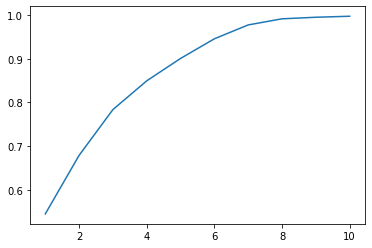

In [63]:
sns.lineplot(np.arange(1, 11), np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [64]:
pca.explained_variance_ratio_

array([0.54478706, 0.13402893, 0.10474809, 0.06576355, 0.05122304,
       0.04494931, 0.03172879, 0.01396816, 0.00359087, 0.00230245])

In [65]:
np.cumsum(pca.explained_variance_ratio_)

array([0.54478706, 0.67881599, 0.78356408, 0.84932763, 0.90055067,
       0.94549998, 0.97722877, 0.99119694, 0.9947878 , 0.99709026])

In [66]:
pca = PCA(n_components=8)
X = pca.fit_transform(df.drop(["Trimestre", "CODIGO_CLIENTE"], axis=1))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


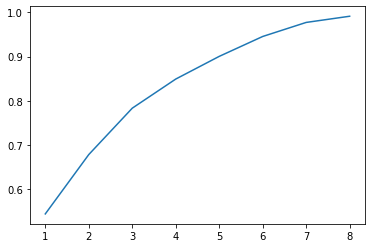

In [67]:
sns.lineplot(np.arange(1, 9), np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [68]:
np.cumsum(pca.explained_variance_ratio_)

array([0.54478706, 0.67881599, 0.78356408, 0.84932763, 0.90055067,
       0.94549998, 0.97722877, 0.99119694])

In [69]:
def evaluate(model, df):
    labels = model.labels_
    a = silhouette_score(df, labels, metric='euclidean')
    b = calinski_harabasz_score(df, labels)
    c = davies_bouldin_score(df, labels)
    return [a, c ,b]

In [70]:
sample = df.drop(["Trimestre", "CODIGO_CLIENTE"], axis=1).sample(frac=0.08, random_state=42)
pca = PCA(n_components=8)
X = pca.fit_transform(sample)
X = pd.DataFrame(X).iloc[:, :5]

In [71]:
scores = pd.DataFrame(columns=["Silhouette", "Calinsky", "Davies"])

In [72]:
for i in range(2, 8):
  kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
  X["kmeans"] = np.transpose(kmeans.labels_)
  s, c, d = evaluate(kmeans, X)
  scores = scores.append({"Calinsky":c, "Davies":d, "Silhouette":s}, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


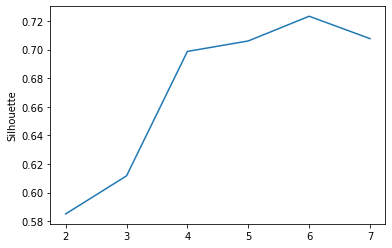

In [73]:
sns.lineplot(scores["Silhouette"].index+2, scores["Silhouette"])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


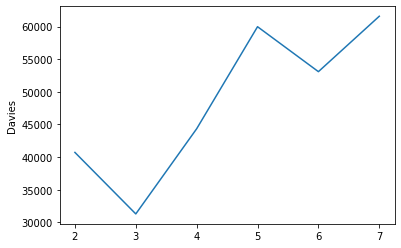

In [74]:
sns.lineplot(scores["Davies"].index+2, scores["Davies"])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


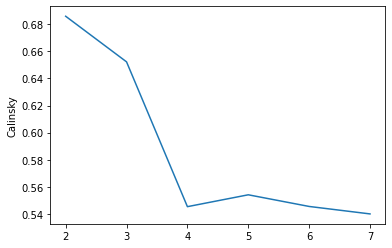

In [75]:
sns.lineplot(scores["Calinsky"].index+2, scores["Calinsky"])
plt.show()

In [77]:
df_s = df.copy()

In [78]:
pca = PCA(n_components=8)
X = pd.DataFrame(pca.fit_transform(df_s.drop(["Trimestre", "CODIGO_CLIENTE"], axis=1))).iloc[:, :5].copy()
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
X["cluster"] = np.transpose(kmeans.labels_)

In [79]:
df_s[numericas] = scaler.inverse_transform(df_s[numericas])

In [80]:
df_s["cluster"] = np.transpose(kmeans.labels_)

In [81]:
fracs = df_s.groupby("cluster").sum()[["NUMERADOR_RATIO_RENTABILIDAD", "DENOMINADOR_RATIO_RENTABILIDAD"]]
fracs["NUMERADOR_RATIO_RENTABILIDAD"]/fracs["DENOMINADOR_RATIO_RENTABILIDAD"]

cluster
0   -3.201027
1    0.391298
2   -1.470811
3    3.826927
4    0.227698
5   -0.110868
6    0.695271
7    2.799708
dtype: float64

In [82]:
import plotly.express as px
fig = px.scatter_3d(X.sample(frac=0.1), x=1, y=0, z=3, color='cluster')
fig.show()

In [83]:
socio_complete = data_info["Sociodemografica"].drop(columns=['TIPO_DOCUMENTO', 'SEGMENTO_COMERCIAL', 'GRUPO_RIESGO', 'INGRESO_MENSUAL', 'NUMERO_DOCUMENTO','DEPENDIENTES','SITUACION_LABORAL','TIPO_EMPLEO', 'PERIODO', 'TIPO_PROFESION'])


In [84]:
socio_complete

,CODIGO_CLIENTE,EDAD,GENERO,UBIGEO_DIRECCION,ESTADO_CIVIL,AFILIACION_SMS,AFILIACION_BANCA_ONLINE,Trimestre
504583,89291880,33.0,M,108004.0,C,SI,SI,2019Q4
117272,45485655,20.0,F,101035.0,S,SI,SI,2021Q2
427770,98126400,26.0,F,101029.0,S,SI,SI,2019Q3
1520101,23243466,58.0,F,418009.0,C,NO,NO,2021Q2
149722,97458870,65.0,F,101043.0,S,NO,NO,2019Q1
...,...,...,...,...,...,...,...,...
806689,35788391,27.0,M,1901013.0,S,NO,NO,2019Q1
319370,68902988,51.0,F,804006.0,S,SI,SI,2019Q3
1051873,63148394,73.0,F,108011.0,C,NO,NO,2021Q2
721908,42714164,58.0,M,2101012.0,C,NO,NO,2020Q4


In [85]:
socio_complete["Trimestre"] = socio_complete.Trimestre.astype(str)

In [86]:
df_s["Trimestre"] = df_s["Trimestre"].astype(str)

In [87]:
df_final = df_s.merge(socio_complete, on=["Trimestre", "CODIGO_CLIENTE"], how='inner')

In [88]:
df_final_final = df_final.groupby(["Trimestre", "CODIGO_CLIENTE"]).last()

In [89]:
df_final_final

SALDO_PUNTUAL  ...  AFILIACION_BANCA_ONLINE
Trimestre CODIGO_CLIENTE                 ...                         
2020Q1    1484                  1679.05  ...                       NO
          1627                     0.00  ...                       SI
          2726                  4127.66  ...                       SI
          8020                 17420.82  ...                       SI
          13533                  441.52  ...                       SI
...                                 ...  ...                      ...
2021Q2    99990688                 0.06  ...                       NO
          99992653              4904.93  ...                       SI
          99995605             16685.23  ...                       SI
          99996507             23783.98  ...                       SI
          99998660                 0.00  ...                       NO

[309363 rows x 52 columns]

In [90]:
df_final_final.reset_index(["Trimestre", "CODIGO_CLIENTE"])
df_final_final.to_csv("clusters_buenos.csv")

## Insights

In [91]:
df_final_final.head()

SALDO_PUNTUAL  ...  AFILIACION_BANCA_ONLINE
Trimestre CODIGO_CLIENTE                 ...                         
2020Q1    1484                  1679.05  ...                       NO
          1627                     0.00  ...                       SI
          2726                  4127.66  ...                       SI
          8020                 17420.82  ...                       SI
          13533                  441.52  ...                       SI

[5 rows x 52 columns]

In [92]:
rentabilidad_cliente_producto.reset_index(["Trimestre", "CODIGO_CLIENTE", "PRODUCTO"], inplace=True)
rentabilidad_cliente_producto["Trimestre"] = rentabilidad_cliente_producto.Trimestre.astype(str)

In [93]:
rentabilidad_cliente_producto.merge(df_final_final, on=["Trimestre", "CODIGO_CLIENTE"], how='left').to_csv("rent prod clus.csv")

In [94]:
rentabilidad_cliente_producto.to_csv("rentabilidad producto.csv")

In [95]:
rentabilidad_cliente_producto

,Trimestre,CODIGO_CLIENTE,PRODUCTO,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD
0,2020Q1,42599,CONSUMO,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
1,2020Q1,54895,CONSUMO,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
2,2020Q1,57262,CONSUMO,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
3,2020Q1,67416,CONSUMO,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
4,2020Q1,78120,TARJETAS,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
94385,2021Q2,99984516,TJ_EMPRESAS,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
94386,2021Q2,99985143,CONSUMO,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
94387,2021Q2,99985143,TARJETAS,0.0,0.000000,0.000000,0.000000,36260.4747,226.372009,-170.610876,0.00000,0.000000
94388,2021Q2,99985967,CONSUMO,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000


In [96]:
data_info["RCC"].head()

,CODIGO_CLIENTE,TIPO_DOCUMENTO,NUMERO_DOCUMENTO,ENTIDAD,TIPO_MOVIMIENTO,PRODUCTO,DETALLE_PRODUCTO,DIVISA,SALDO,DIAS_ATRASO,PERIODO
367937,49516289,1,22004914.0,OTRO,10,CONSUMO,TARJETAS,1,20070.69,0,2020-03-01
582819,14589597,1,52810790.0,OTRO,10,CONSUMO,TARJETAS,1,564.33,0,2020-11-01
861293,41959857,1,10967735.0,BBVA,14,CONSUMO,TARJETAS,1,60.00,11,2021-01-01
1131560,75938465,1,79613266.0,OTRO,10,CONSUMO,TARJETAS,1,1916.79,0,2021-06-01
742413,45375192,1,37178106.0,OTRO,10,CONSUMO,CONSUMO,1,14808.72,0,2021-02-01


In [97]:
data_info["RCC"]["Trimestre"] = pd.PeriodIndex(data_info["RCC"]["PERIODO"], freq='Q')

In [98]:
rcc = data_info["RCC"].drop(columns=["TIPO_DOCUMENTO", "NUMERO_DOCUMENTO", "DIVISA", "TIPO_MOVIMIENTO"]).groupby(["Trimestre", "CODIGO_CLIENTE", "ENTIDAD", "PRODUCTO", "DETALLE_PRODUCTO"]).sum()

In [99]:
rcc.reset_index(["Trimestre", "CODIGO_CLIENTE", "ENTIDAD", "PRODUCTO", "DETALLE_PRODUCTO"], inplace=True)

In [100]:
rcc["Trimestre"] = data_info["RCC"]["Trimestre"].astype(str)

In [101]:
rcc.merge(df_final_final, on=["Trimestre", "CODIGO_CLIENTE"], how='inner').to_csv("productos posibles.csv")

In [102]:
rcc.merge(df_final_final, on=["Trimestre", "CODIGO_CLIENTE"], how='inner')

,Trimestre,CODIGO_CLIENTE,ENTIDAD,PRODUCTO,DETALLE_PRODUCTO,SALDO,DIAS_ATRASO,SALDO_PUNTUAL,MARGEN_FINANCIERO,COMISIONES,MARGEN_BRUTO,EXPOSICION_DEFAULT,PERDIDA_ESPERADA,NUMERADOR_RATIO_RENTABILIDAD,DENOMINADOR_RATIO_RENTABILIDAD,RATIO_RENTABILIDAD,SEGMENTO_COMERCIAL,GRUPO_RIESGO,RIESGO1,RIESGO2,RIESGO3,INGRESO_MENSUAL,SALDO_MEDIO_VISTA,SALDO_MEDIO_AHORRO,SALDO_MEDIO_CTS,SALDO_MEDIO_PLAZO,SALDO_MEDIO_FONDO_MUTUO,SALDO_MEDIO_AUTOS,SALDO_MEDIO_CONSUMO,SALDO_MEDIO_TARJETAS,SALDO_MEDIO_HIPOTECARIO,SALDO_MEDIO_CARTERA,SALDO_MEDIO_LEASING,SALDO_MEDIO_PRESTAMOS_COMERCIALES,SALDO_MEDIO_COMEXT,SALDO_MEDIO_TJ_EMPRESAS,FAM_COBRANZAS,FAM_COMEX,FAM_PAGOHABERES,FAM_PROVEEDORES,FAM_SUPPLY,FAM_VISANET,T_NETCASH,T_SEGURO,T_WALLET,T_TCAMBIO,T_AFILIACION_DIGITAL,T_CARGO_RECURRENTE,SALDO_MEDIO_INVERSION_RENTABLE,SALDO_MEDIO_CARTERA_ATRASADA,VINCULACION_PN,VINCULACION_EMPRESA,cluster,EDAD,GENERO,UBIGEO_DIRECCION,ESTADO_CIVIL,AFILIACION_SMS,AFILIACION_BANCA_ONLINE
0,2020Q1,2726,OTRO,PEQUE�AS EMPRESAS,PRESTAMOS_COMERCIALES,89802.11,0,4127.66,148.202436,0.000000,148.202436,0.0000,0.000000,104.482717,26.120679,4.000000,3,1,0,0,0,1868.31,0.00,3532.48,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,0.0,0.0,0.0,4,26.0,F,2006008.0,S,SI,SI
1,2020Q1,2726,OTRO,PEQUE�AS EMPRESAS,PRESTAMOS_COMERCIALES,104707.71,0,4127.66,148.202436,0.000000,148.202436,0.0000,0.000000,104.482717,26.120679,4.000000,3,1,0,0,0,1868.31,0.00,3532.48,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,0.0,0.0,0.0,4,26.0,F,2006008.0,S,SI,SI
2,2020Q1,8020,OTRO,CONSUMO,TARJETAS,4925.73,0,17420.82,619.480238,159.629644,779.109882,0.0000,0.000000,549.272467,137.318117,4.000000,1,1,0,0,0,2978.98,0.00,9868.90,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.00,0.0,0.0,0.0,1,27.0,M,101013.0,S,SI,SI
3,2020Q1,8020,OTRO,CONSUMO,TARJETAS,3281.99,0,17420.82,619.480238,159.629644,779.109882,0.0000,0.000000,549.272467,137.318117,4.000000,1,1,0,0,0,2978.98,0.00,9868.90,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.00,0.0,0.0,0.0,1,27.0,M,101013.0,S,SI,SI
4,2020Q1,18614,OTRO,MICROEMPRESAS,PRESTAMOS_COMERCIALES,6221.27,0,36.59,1.385439,0.000000,1.385439,0.0000,0.000000,0.976734,0.244184,3.999998,1,2,2,1,0,1868.06,0.00,591.35,14.94,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,0.0,0.0,0.0,5,41.0,F,2006008.0,S,SI,SI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220448,2020Q1,99968182,BBVA,CONSUMO,CONSUMO,96000.00,0,24.72,0.967845,0.000000,0.967845,0.0000,0.000000,0.682330,0.170583,3.999996,1,2,2,0,0,1414.38,0.00,24.72,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,0.0,0.0,0.0,5,41.0,F,101013.0,S,SI,SI
220449,2020Q1,99968182,OTRO,CONSUMO,CONSUMO,68312.26,0,24.72,0.967845,0.000000,0.967845,0.0000,0.000000,0.682330,0.170583,3.999996,1,2,2,0,0,1414.38,0.00,24.72,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,0.0,0.0,0.0,5,41.0,F,101013.0,S,SI,SI
220450,2020Q1,99968182,OTRO,PEQUE�AS EMPRESAS,PRESTAMOS_COMERCIALES,4743.40,0,24.72,0.967845,0.000000,0.967845,0.0000,0.000000,0.682330,0.170583,3.999996,1,2,2,0,0,1414.38,0.00,24.72,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.00,0.0,0.0,0.0,5,41.0,F,101013.0,S,SI,SI
220451,2020Q1,99977234,BBVA,CONSUMO,TARJETAS,1250.76,0,20085.73,677.890916,3.430757,681.321673,10455.4743,31.791696,457.918633,270.337560,1.693877,1,0,0,0,0,4086.62,0.00,16858.43,0.00,0.0,0.0,0.0,0.0,783.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,783.99,0.0,0

In [103]:
rcc.head()

,Trimestre,CODIGO_CLIENTE,ENTIDAD,PRODUCTO,DETALLE_PRODUCTO,SALDO,DIAS_ATRASO
0,2020Q1,2726,OTRO,PEQUE�AS EMPRESAS,PRESTAMOS_COMERCIALES,89802.11,0
1,2020Q1,8020,OTRO,CONSUMO,TARJETAS,4925.73,0
2,2020Q1,11065,OTRO,CONSUMO,CONSUMO,3006.57,0
3,2020Q1,11065,OTRO,MICROEMPRESAS,PRESTAMOS_COMERCIALES,2183.93,0
4,2020Q1,18614,OTRO,MICROEMPRESAS,PRESTAMOS_COMERCIALES,6221.27,0
